<a href="https://colab.research.google.com/github/chandrikakhagga/Europetrainpridiction/blob/main/Copy_of_Copy_of_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.gridspec as gridspec

from collections import Counter

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report,accuracy_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [ ]:
data = pd.read_csv('/content/Money_Laundering_Dataset (1).csv')

In [ ]:
data.shape

(27656, 12)

In [ ]:
data.head().style.set_properties(**{"background-color":"black","color" : "lawngreen"})

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0.000000,1,PAYMENT,9839.640000,C1231006815,170136.000000,160296.360000,M1979787155,0.000000,0.000000,0.000000,0.000000
1,1.000000,1,PAYMENT,1864.280000,C1666544295,21249.000000,19384.720000,M2044282225,0.000000,0.000000,0.000000,0.000000
2,2.000000,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1.000000,0.000000
3,3.000000,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1.000000,0.000000
4,4.000000,1,PAYMENT,11668.140000,C2048537720,41554.000000,29885.860000,M1230701703,0.000000,0.000000,0.000000,0.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27656 entries, 0 to 27655
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      27653 non-null  float64
 1   step            27656 non-null  int64  
 2   type            27656 non-null  object 
 3   amount          27656 non-null  float64
 4   nameOrig        27646 non-null  object 
 5   oldbalanceOrg   27643 non-null  float64
 6   newbalanceOrig  27655 non-null  float64
 7   nameDest        27651 non-null  object 
 8   oldbalanceDest  27655 non-null  float64
 9   newbalanceDest  27655 non-null  float64
 10  isFraud         27655 non-null  float64
 11  isFlaggedFraud  27633 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 2.5+ MB


In [ ]:
data.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [ ]:
data[['oldbalanceOrg', 'amount','newbalanceDest','isFraud']].describe().style.set_properties(**{"background-color":"black","color" : "yellow"})

,oldbalanceOrg,amount,newbalanceDest,isFraud
count,27643.000000,27656.000000,27655.000000,27655.000000
mean,777335.066629,134669.616772,1189777.922540,0.011210
std,2142844.571118,300667.783012,3114074.724089,0.105282
min,0.000000,1.770000,0.000000,0.000000
25%,0.000000,5918.057500,0.000000,0.000000
50%,19934.000000,18996.575000,0.000000,0.000000
75%,141578.010000,158603.362500,637928.740000,0.000000
max,22352310.120000,10000000.000000,28783585.380000,1.000000


In [ ]:
summary = (data[data['amount'] == 1].describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['skyblue']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [150,60,100,100,80,80,80,80,80])
layout = go.Layout(dict(title = "Summary for fraudulent Transactions"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


In [ ]:

print(f'Percent of Non-Fraudulent Transactions = {round(data["isFraud"].value_counts()[0]/len(data) * 100,3)}%')
print(f'Percent of Fraudulent Transactions = {round(data["isFraud"].value_counts()[1]/len(data) * 100,3)}%')

Percent of Non-Fraudulent Transactions = 98.875%
Percent of Fraudulent Transactions = 1.121%


In [ ]:
# plotting a pie chart for fraud and non-fraud transactions

fraud_or_not = data["isFraud"].value_counts().tolist()

labels = ['Not Fraud','Frauds']
values = [fraud_or_not[0], fraud_or_not[1]]
colors = ['skyblue', 'red']

trace = go.Pie(labels=labels, values=values, textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))

plotly.offline.iplot([trace], filename='styled_pie_chart')

In [ ]:
print('\n\033[1m  Fraudulent Transaction Distribution by amount \033[0m')
print("-"*50)
print(data[(data['isFraud'] == 1)]['amount'].value_counts().head())


  Fraudulent Transaction Distribution by amount 
--------------------------------------------------
181.00       2
18627.02     2
60726.57     2
120074.73    2
86070.17     2
Name: amount, dtype: int64


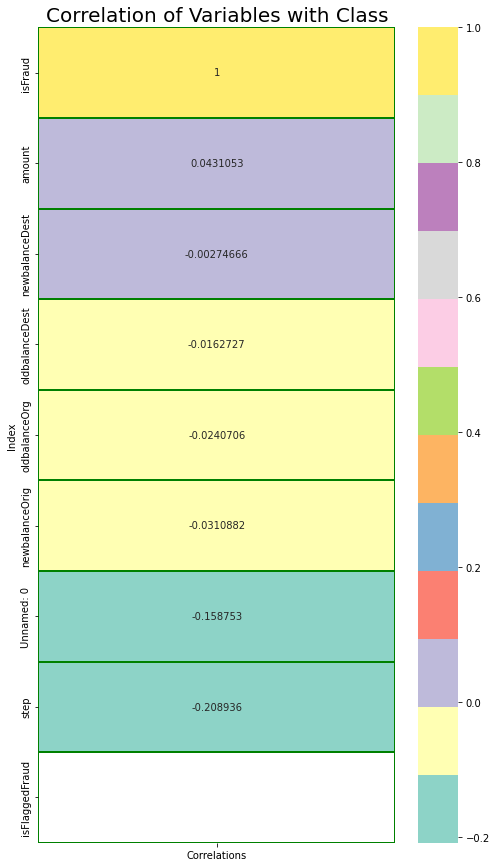

In [ ]:
corr = data.corrwith(data['isFraud']).reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)

plt.figure(figsize=(8, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=20)
plt.show()

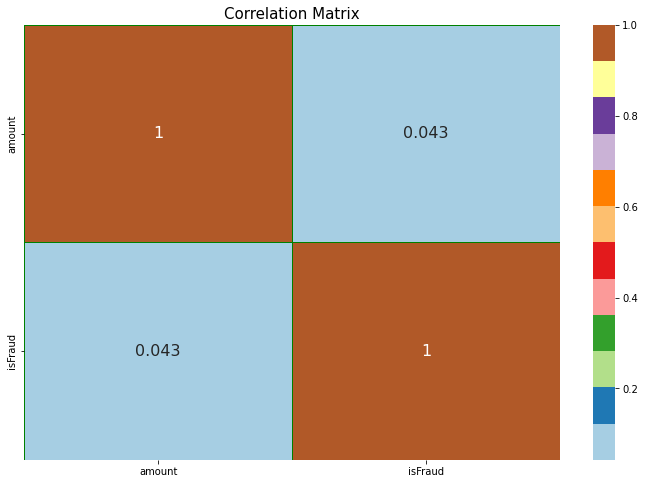

In [ ]:
# Heatmap for explainatory variables

plt.subplots(figsize=(12,8))
plt.title("Correlation Matrix", fontsize=15)
sns.heatmap(data[['type', 'amount','isFraud']].corr(),linewidths=0.9, cmap="Paired", linecolor='green',annot=True, annot_kws={'size':16},);

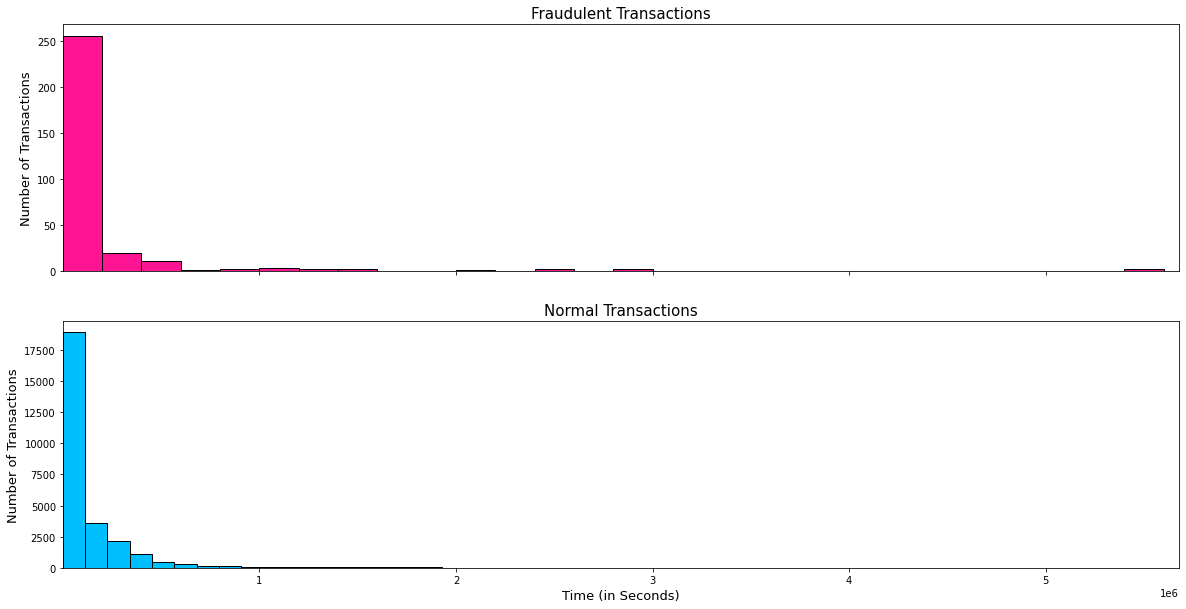

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

fraud_transactions = data.amount[data.isFraud == 1]
normal_transactions = data.amount[data.isFraud == 0]

ax1.hist(fraud_transactions, bins = 50, color='deeppink', edgecolor="black")
ax1.set_xlim([min(fraud_transactions), max(fraud_transactions)])
ax1.set_title('Fraudulent Transactions', fontsize=15)
ax1.set_ylabel("Number of Transactions",  fontsize=13)

ax2.hist(normal_transactions, bins = 50, color='deepskyblue', edgecolor="black")
ax2.set_xlim([min(normal_transactions), max(normal_transactions)])
ax2.set_title('Normal Transactions',  fontsize=15)

ax2.set_xlabel('Time (in Seconds)',  fontsize=13)
ax2.set_ylabel('Number of Transactions',  fontsize=13)

plt.show()

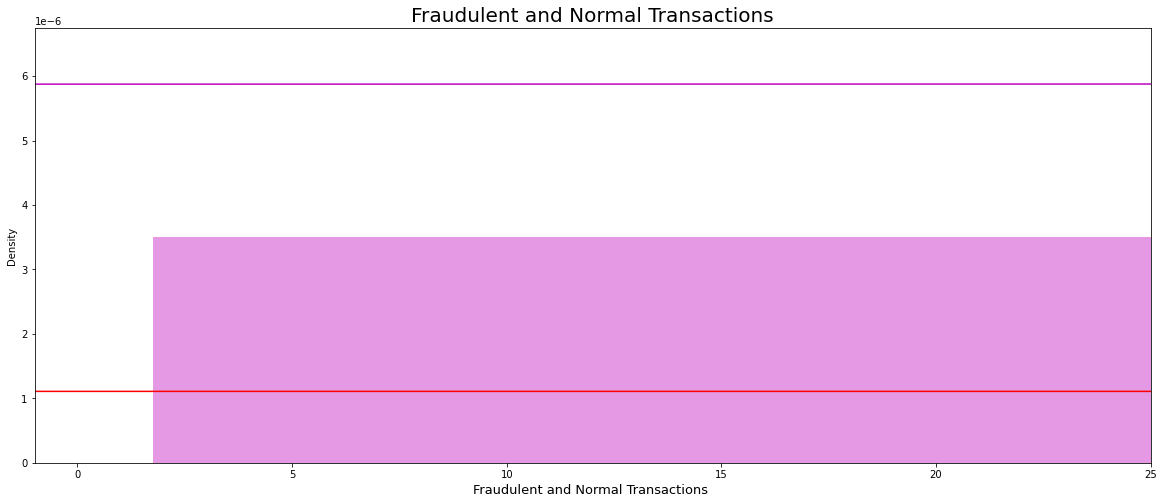

In [ ]:
# Exploring the distribuition by Class types throught hours and minutes

plt.figure(figsize=(20,8))

sns.distplot(data[data['isFraud'] == 0]['amount'], bins=24, color='m')
sns.distplot(data[data['isFraud'] == 1]["amount"], bins=24, color='r')

plt.title('Fraudulent and Normal Transactions', fontsize=20)

plt.xlabel("Fraudulent and Normal Transactions ", fontsize=13)
plt.xlim([-1,25])
plt.show()

In [ ]:
temp = data.copy()

In [ ]:
Q3 = np.percentile(data['amount'], 75)
Q1 = np.percentile(data['amount'], 25)

In [ ]:
cutoff = 5.0

In [ ]:
IQR = (Q3 - Q1)

In [ ]:
lower_bound = Q1 - (IQR * cutoff)
upper_bound = Q3 + (IQR * cutoff)

# creating a filter to remove values less than lower bound and greater than
# upper bound
filter_data = (data['amount'] < lower_bound) | (data['amount'] > upper_bound)

# filtering data
outliers = data[filter_data]['amount']
fraud_outliers = data[(data['isFraud'] == 1) & filter_data]['amount']
normal_outliers = data[(data['isFraud'] == 0) & filter_data]['amount']

print(f"Total Number of Outliers : {outliers.count()}")
print(f"Number of Outliers in Fraudulent Class : {fraud_outliers.count()}")
print(f"No of Outliers in Normal Class : {normal_outliers.count()}")
print(f"Percentage of Fraud amount outliers : {round((fraud_outliers.count()/outliers.count())*100,2)}%")

Total Number of Outliers : 672
Number of Outliers in Fraudulent Class : 22
No of Outliers in Normal Class : 650
Percentage of Fraud amount outliers : 3.27%


In [ ]:
# applying log transformation of Amount column

data['amount'] = np.log(data['amount'] + 0.001)

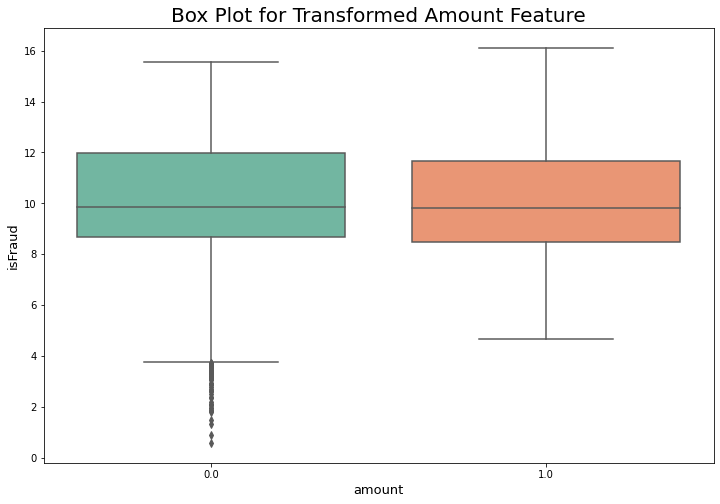

In [ ]:
# Box Plot for transformed Amount feature with class

plt.figure(figsize=(12,8))
sns.boxplot(x ="isFraud", y="amount", data=data, palette='Set2');
plt.xlabel("amount", fontsize=13)
plt.ylabel("isFraud", fontsize=13)
plt.title("Box Plot for Transformed Amount Feature", fontsize=20);

In [ ]:
df=data.drop(['Unnamed: 0', 'step','nameOrig','nameDest','isFlaggedFraud'], axis=1)

In [ ]:
df['isFraud'] = df['isFraud'].fillna(df['isFraud'].mean())
df.isnull().sum()



type               0
amount             0
oldbalanceOrg     13
newbalanceOrig     1
oldbalanceDest     1
newbalanceDest     1
isFraud            0
dtype: int64

In [ ]:
df[ 'type' ] = df[ 'type' ].astype( 'category' ) 
print("\nData Frame after Label Encoding using Category codes:\n")  
df[ 'type' ] = df[ 'type' ].cat.codes  
  
print(df)    


Data Frame after Label Encoding using Category codes:

       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         3   9.194175       170136.0       160296.36            0.00   
1         3   7.530631        21249.0        19384.72            0.00   
2         4   5.198503          181.0            0.00            0.00   
3         1   5.198503          181.0            0.00        21182.00   
4         3   9.364617        41554.0        29885.86            0.00   
...     ...        ...            ...             ...             ...   
27651     0  11.165626       312618.0       264400.64        86394.58   
27652     0  12.886385        25660.0       659299.41      4506548.96   
27653     0  11.252816         4505.0       736396.13      6442111.25   
27654     0  12.577129        11560.0      1026248.94      1199172.88   
27655     0  10.876523            NaN             NaN             NaN   

       newbalanceDest  isFraud  
0                0.00  0.00000  
1

In [ ]:
df['oldbalanceOrg'] = df['oldbalanceOrg'].fillna(df['oldbalanceOrg'].mode()[0])
df['newbalanceOrig'] = df['newbalanceOrig'].fillna(df['newbalanceOrig'].mode()[0])
df['oldbalanceDest'] = df['oldbalanceDest'].fillna(df['oldbalanceDest'].mode()[0])
df['newbalanceDest'] = df['newbalanceDest'].fillna(df['newbalanceDest'].mode()[0])
df.isnull().sum()

type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [ ]:
df['isFraud'] = df['isFraud'].astype(int)

In [ ]:
df['oldbalanceOrg'] = df['oldbalanceOrg'].astype(int)

In [ ]:
df['amount'] = df['amount'].astype(int)

In [ ]:
df['newbalanceOrig'] = df['newbalanceOrig'].astype(int)

In [ ]:
df['oldbalanceDest'] = df['oldbalanceDest'].astype(int)


In [ ]:
df['newbalanceDest'] = df['newbalanceDest'].astype(int)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27656 entries, 0 to 27655
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   type            27656 non-null  int8 
 1   amount          27656 non-null  int64
 2   oldbalanceOrg   27656 non-null  int64
 3   newbalanceOrig  27656 non-null  int64
 4   oldbalanceDest  27656 non-null  int64
 5   newbalanceDest  27656 non-null  int64
 6   isFraud         27656 non-null  int64
dtypes: int64(6), int8(1)
memory usage: 1.3 MB


In [ ]:
print(df)

       type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         3       9         170136          160296               0   
1         3       7          21249           19384               0   
2         4       5            181               0               0   
3         1       5            181               0           21182   
4         3       9          41554           29885               0   
...     ...     ...            ...             ...             ...   
27651     0      11         312618          264400           86394   
27652     0      12          25660          659299         4506548   
27653     0      11           4505          736396         6442111   
27654     0      12          11560         1026248         1199172   
27655     0      10              0               0               0   

       newbalanceDest  isFraud  
0                   0        0  
1                   0        0  
2                   0        1  
3                   0      

In [ ]:
robust_scaler = RobustScaler()
df['newbalanceOrig'] = robust_scaler.fit_transform(df['newbalanceOrig'].values.reshape(-1,1))

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
    
#output vector
y = df.isFraud
  
#input vector
x=df.drop('isFraud',axis=1)
  
#split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)
  
#verify
print("shape of original dataset :", df.shape)
print("shape of input - training set", x_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", x_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (27656, 7)
shape of input - training set (19359, 6)
shape of output - training set (19359,)
shape of input - testing set (8297, 6)
shape of output - testing set (8297,)


In [ ]:
print(x)

       type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         3       9         170136        1.093113               0   
1         3       7          21249        0.106726               0   
2         4       5            181       -0.028963               0   
3         1       5            181       -0.028963           21182   
4         3       9          41554        0.180233               0   
...     ...     ...            ...             ...             ...   
27651     0      11         312618        1.821843           86394   
27652     0      12          25660        4.586143         4506548   
27653     0      11           4505        5.125824         6442111   
27654     0      12          11560        7.154793         1199172   
27655     0      10              0       -0.028963               0   

       newbalanceDest  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...            

In [ ]:
print(y)

0        0
1        0
2        1
3        1
4        0
        ..
27651    0
27652    0
27653    0
27654    0
27655    0
Name: isFraud, Length: 27656, dtype: int64


In [ ]:
print(x)


       type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         3       9         170136        1.093113               0   
1         3       7          21249        0.106726               0   
2         4       5            181       -0.028963               0   
3         1       5            181       -0.028963           21182   
4         3       9          41554        0.180233               0   
...     ...     ...            ...             ...             ...   
27651     0      11         312618        1.821843           86394   
27652     0      12          25660        4.586143         4506548   
27653     0      11           4505        5.125824         6442111   
27654     0      12          11560        7.154793         1199172   
27655     0      10              0       -0.028963               0   

       newbalanceDest  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...            

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder= 'passthrough')
x = np.array(ct.fit_transform(x))

In [ ]:
print(x)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.09311251e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.06725793e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.12582360e+00
   6.44211100e+06  6.09779500e+06]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.15479318e+00
   1.19917200e+06  9.94391000e+05]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
print(y)

[0 0 1 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state= 1)

In [ ]:
print(x_train)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.59751814e-03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.52359969e+00
   1.05047930e+07  1.03889040e+07]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   8.62936000e+05  1.76141300e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.95116087e-02
   0.00000000e+00  0.00000000e+00]]


In [ ]:
print(x_test)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.63218399e+00
   1.87979000e+05  1.27609000e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.03496335e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.84920384e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -2.89625796e-02
   0.00000000e+00  3.94387000e+05]]


In [ ]:
print(y_train)


[0 0 0 ... 0 0 1]


In [ ]:
print(y_test)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we only aply the feature scaling on the features other than dummy variables.
x_train[:, :3] = sc.fit_transform(x_train[:, :3])
x_test[:, 3:] = sc.fit_transform(x_test[:, 3:])


In [ ]:
print(x_train)

[[-4.62145253e-01 -5.20681911e-01 -1.39203448e-01 ... -6.59751814e-03
   0.00000000e+00  0.00000000e+00]
 [-4.62145253e-01 -5.20681911e-01 -1.39203448e-01 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 [ 2.16382186e+00 -5.20681911e-01 -1.39203448e-01 ...  1.52359969e+00
   1.05047930e+07  1.03889040e+07]
 ...
 [-4.62145253e-01 -5.20681911e-01 -1.39203448e-01 ... -2.89625796e-02
   0.00000000e+00  0.00000000e+00]
 [-4.62145253e-01  1.92055837e+00 -1.39203448e-01 ... -2.89625796e-02
   8.62936000e+05  1.76141300e+06]
 [-4.62145253e-01 -5.20681911e-01 -1.39203448e-01 ...  3.95116087e-02
   0.00000000e+00  0.00000000e+00]]


In [ ]:
print(x_test)

[[ 1.          0.          0.         ... -0.26307333 -0.25924603
  -0.33794367]
 [ 0.          0.          0.         ... -0.34943306 -0.33381681
  -0.37918245]
 [ 0.          0.          0.         ... -0.37104164 -0.33381681
  -0.37918245]
 ...
 [ 0.          0.          0.         ... -0.37104164 -0.33381681
  -0.37918245]
 [ 0.          0.          0.         ... -0.32464192 -0.33381681
  -0.37918245]
 [ 0.          1.          0.         ... -0.37104164 -0.33381681
  -0.25173032]]


In [ ]:
# Create the classifier and fit it to our training data
model = RandomForestClassifier(random_state=7, n_estimators=100)
model.fit(x_train, y_train)


RandomForestClassifier(random_state=7)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
# Predict classes given the validation features
pred_y = model.predict(x_test)

# Calculate the accuracy as our performance metric
accuracy = metrics.accuracy_score(y_test, pred_y)
print("Accuracy: ", accuracy)

Accuracy:  0.7032662408099313


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2)

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="Set2")
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve,auc )
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_res, y_res = rus.fit_resample(x_train, y_train)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_true = [0, 1, 2, 0, 1, 2]  # ground truth labels
y_pred = [0, 2, 1, 0, 0, 1]  # predicted labels

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 0.2222222222222222
Recall: 0.3333333333333333
F1 score: 0.26666666666666666


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_predtrain = clf.predict(x_train)
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
CM_LRtrain = confusion_matrix(y_train,y_predtrain)
CR_LRtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)
print("Confusion Matrix Train:\n",CM_LRtrain)
print("Classification Report Train:\n",CR_LRtrain)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
accuracy = metrics.accuracy_score(y_test, pred_y)
print("Accuracy: ", accuracy)

Accuracy: 0.4927082077859467
Confusion Matrix:
 [[4033 4164]
 [  45   55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.49      0.66      8197
           1       0.01      0.55      0.03       100

    accuracy                           0.49      8297
   macro avg       0.50      0.52      0.34      8297
weighted avg       0.98      0.49      0.65      8297

Confusion Matrix Train:
 [[19146     3]
 [  210     0]]
Classification Report Train:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19149
           1       0.00      0.00      0.00       210

    accuracy                           0.99     19359
   macro avg       0.49      0.50      0.50     19359
weighted avg       0.98      0.99      0.98     19359

Precision: 0.013036264517658214
Recall: 0.55
F1: 0.02546885853206761
Area under precision (AUC) Recall: 0.012593592586073956
Accuracy:  0.7032662408099313


In [ ]:
clf = BernoulliNB()
clf.fit(X_res, y_res)
y_pred = clf.predict(x_test)
y_predtrain = clf.predict(x_train)
CM_NB = confusion_matrix(y_test,y_pred)
CR_NB = classification_report(y_test,y_pred)
CM_NBtrain = confusion_matrix(y_train,y_predtrain)
CR_NBtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_NB)
print("Classification Report:\n",CR_NB)
print("Confusion Matrix Train:\n",CM_NBtrain)
print("Classification Report Train:\n",CR_NBtrain)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
accuracy = metrics.accuracy_score(y_test, pred_y)
print("Accuracy: ", accuracy)

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X_res, y_res)
y_pred=clf.predict(x_test)
y_predtrain=clf.predict(x_train)
SGDClassifier(max_iter=5)
CM_svc = confusion_matrix(y_test,y_pred)
CR_svc = classification_report(y_test,y_pred)
CM_svctrain = confusion_matrix(y_train,y_predtrain)
CR_svctrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_svc)
print("Classification Report:\n",CR_svc)
print("Confusion Matrix Train:\n",CM_svctrain)
print("Classification Report Train:\n",CR_svctrain)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.22249005664698085
Confusion Matrix:
 [[1755 6442]
 [   9   91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.21      0.35      8197
           1       0.01      0.91      0.03       100

    accuracy                           0.22      8297
   macro avg       0.50      0.56      0.19      8297
weighted avg       0.98      0.22      0.35      8297

Confusion Matrix Train:
 [[15667  3482]
 [  170    40]]
Classification Report Train:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     19149
           1       0.01      0.19      0.02       210

    accuracy                           0.81     19359
   macro avg       0.50      0.50      0.46     19359
weighted avg       0.98      0.81      0.89     19359

Precision: 0.01392928210622991
Recall: 0.91
F1: 0.027438564751997588
Area under precision (AUC) Recall: 0.013760376136941605


In [ ]:
RF = RandomForestClassifier(n_estimators=15,oob_score=True,class_weight='balanced',n_jobs=-1)


RF.fit(x_train, y_train)

y_pred= RF.predict(x_test)
y_predtrain=RF.predict(x_train) 
     
# Evaluating model
CM_RF_train=confusion_matrix(y_train,y_predtrain)
CR_RF_train= classification_report(y_train,y_predtrain)
CM_RF = confusion_matrix(y_test,y_pred)
CR_RF = classification_report(y_test,y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_RF)
print("Classification Report:\n",CR_RF)
print("Confusion Matrix Train Data:\n",CM_RF_train)
print("Classification Report Train Data:\n",CR_RF_train)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.8961070266361335
Confusion Matrix:
 [[7412  785]
 [  77   23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95      8197
           1       0.03      0.23      0.05       100

    accuracy                           0.90      8297
   macro avg       0.51      0.57      0.50      8297
weighted avg       0.98      0.90      0.93      8297

Confusion Matrix Train Data:
 [[18584   565]
 [   24   186]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     19149
           1       0.25      0.89      0.39       210

    accuracy                           0.97     19359
   macro avg       0.62      0.93      0.69     19359
weighted avg       0.99      0.97      0.98     19359

Precision: 0.028465346534653466
Recall: 0.23
F1: 0.050660792951541855
Area under precision (AUC) Recall: 0.01582749252085628


In [ ]:
RF = RandomForestClassifier(n_estimators=15,oob_score=True,n_jobs=-1)


RF.fit(X_res, y_res)

y_pred= RF.predict(x_test)
y_predtrain=RF.predict(x_train) 
     
# Evaluating model
CM_RF_train=confusion_matrix(y_train,y_predtrain)
CR_RF_train= classification_report(y_train,y_predtrain)
CM_RF = confusion_matrix(y_test,y_pred)
CR_RF = classification_report(y_test,y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_RF)
print("Classification Report:\n",CR_RF)
print("Confusion Matrix Train Data:\n",CM_RF_train)
print("Classification Report Train Data:\n",CR_RF_train)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))

Accuracy: 0.6439676991683742
Confusion Matrix:
 [[5282 2915]
 [  39   61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.64      0.78      8197
           1       0.02      0.61      0.04       100

    accuracy                           0.64      8297
   macro avg       0.51      0.63      0.41      8297
weighted avg       0.98      0.64      0.77      8297

Confusion Matrix Train Data:
 [[18071  1078]
 [   15   195]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     19149
           1       0.15      0.93      0.26       210

    accuracy                           0.94     19359
   macro avg       0.58      0.94      0.62     19359
weighted avg       0.99      0.94      0.96     19359

Precision: 0.02049731182795699
Recall: 0.61
F1: 0.03966189856957087
Area under precision (AUC) Recall: 0.017203854369567444


In [ ]:
print("Confusion Matrix:\n",CM_RF)
print("Classification Report:\n",CR_RF)
print("Confusion Matrix Train Data:\n",CM_RF_train)
print("Classification Report Train Data:\n",CR_RF_train)

Confusion Matrix:
 [[5282 2915]
 [  39   61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.64      0.78      8197
           1       0.02      0.61      0.04       100

    accuracy                           0.64      8297
   macro avg       0.51      0.63      0.41      8297
weighted avg       0.98      0.64      0.77      8297

Confusion Matrix Train Data:
 [[18071  1078]
 [   15   195]]
Classification Report Train Data:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     19149
           1       0.15      0.93      0.26       210

    accuracy                           0.94     19359
   macro avg       0.58      0.94      0.62     19359
weighted avg       0.99      0.94      0.96     19359



In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


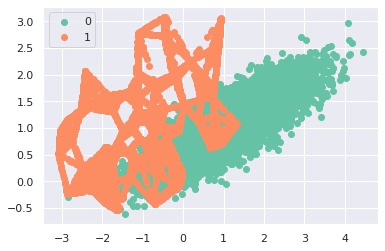

In [ ]:

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
x, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 pyplot.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [ ]:

# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [ ]:

...
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)

In [ ]:

...
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.33%


In [ ]:
# Support Vector Machines
svc = SVC(gamma=10)
svc.fit(x_train, y_train)
Y_pred = svc.predict(x_train)
svc.score(x_train, y_train)

0.9991735110284622

In [ ]:
cross_val_score(SVC(C=10), x_train,y_train, cv=3, scoring="f1")

array([0.02702703, 0.        , 0.        ])

In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor


In [ ]:
rfrModel = RandomForestRegressor()
rfrModel.fit(x_train,y_train)
preds = rfrModel.predict(x_train)
predictions = [round(value) for value in preds]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.91%


              precision    recall  f1-score   support

           0       0.99      0.64      0.78      8197
           1       0.02      0.61      0.04       100

    accuracy                           0.64      8297
   macro avg       0.51      0.63      0.41      8297
weighted avg       0.98      0.64      0.77      8297



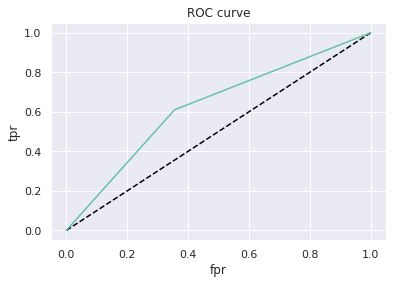

In [ ]:
from keras.layers import Dropout
classifier = Sequential()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(x_train, y_train)
    training_scores.append(ridge.score(x_train, y_train))
    test_scores.append(ridge.score(x_test, y_test))
    ridge_models[alpha] = ridge
for train,test in zip(training_scores,test_scores):
    print (train,test)

0.00845070172014084 -0.15931352838865065
0.008466999380787987 -0.1804148301128914
0.008467182883305724 -0.1827438605325773
0.00846718475955377 -0.18300270799826657


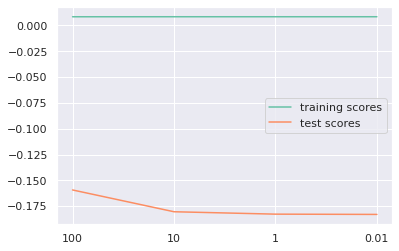

In [ ]:
plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [100, 10, 1, .01])
plt.legend(loc="best")

In [ ]:
ridgeRegModel = Ridge(alpha=.01).fit(x_train,y_train)
ridgePred = ridgeRegModel.predict(x_test)
ridge_predictions = [round(value) for value in ridgePred]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, ridge_predictions) * 100.0))

Accuracy: 98.79%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
kneighbor_regression = KNeighborsRegressor(n_neighbors=1)
kneighbor_regression.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [ ]:
x_knr_pred = kneighbor_regression.predict(x_train)
knr_predictions = [round(value) for value in x_knr_pred]

print("Accuracy: %.2f%%" % (accuracy_score(y_train, knr_predictions) * 100.0))

Accuracy: 99.92%


In [ ]:
y_pred_test = kneighbor_regression.predict(x_test)
y_knr_predictions = [round(value) for value in y_pred_test]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_knr_predictions) * 100.0))

Accuracy: 98.79%


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense

model = Sequential()
model.add(Reshape((10,1), input_shape=(10,1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(10,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier = Sequential()


# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(x_train, y_train, batch_size = 10, epochs = 5)

score, acc = classifier.evaluate(x_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(x_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)


Epoch 1/5
1936/1936 [==============================] - 5s 2ms/step - loss: 5.9656 - accuracy: 0.0000e+00
Epoch 2/5
1936/1936 [==============================] - 5s 2ms/step - loss: 5.9656 - accuracy: 0.0000e+00
Epoch 3/5
1936/1936 [==============================] - 5s 3ms/step - loss: 5.9656 - accuracy: 0.0000e+00
Epoch 4/5
1936/1936 [==============================] - 5s 3ms/step - loss: 5.9656 - accuracy: 0.0000e+00
Epoch 5/5
1936/1936 [==============================] - 4s 2ms/step - loss: 5.9656 - accuracy: 0.0000e+00
Train score: 5.965628623962402
Train accuracy: 0.0
260/260 [==============================] - 0s 1ms/step
********************
830/830 [==============================] - 2s 2ms/step - loss: 2.6098 - accuracy: 0.0323
Test score: 2.60978627204895
Test accuracy: 0.03230082988739014


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(10, 10)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()

    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

In [ ]:
print('Mean accuracy score of 10 different models using Kfold cross validation: {}'.format(mean))
print('Standard Deviation of accuracy score of 10 different models using Kfold cross validation: {}'.format(variance))

Mean accuracy score of 10 different models using Kfold cross validation: 0.0
Standard Deviation of accuracy score of 10 different models using Kfold cross validation: 0.0


In [ ]:
# Improving the ANN
from keras.layers import Dropout
classifier = Sequential()

classifier.add(Dropout(rate = 0.1))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(x_train, y_train, batch_size = 10, epochs = 100,verbose = 0)
# Part 3 - Making predictions and evaluating the model

score, acc = classifier.evaluate(x_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(x_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

1936/1936 [==============================] - 4s 2ms/step - loss: 208.2517 - accuracy: 0.9892
Train score: 208.25167846679688
Train accuracy: 0.9891523122787476
260/260 [==============================] - 0s 2ms/step
********************
830/830 [==============================] - 2s 3ms/step - loss: 1.1584 - accuracy: 0.8916
Test score: 1.158414602279663
Test accuracy: 0.8916475772857666


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 12.5, 'Predicted label')

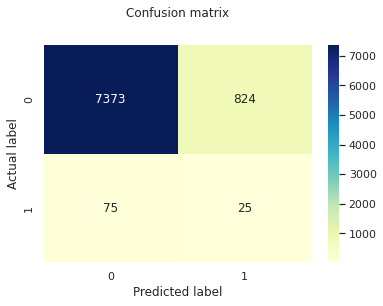

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8197
           1       0.03      0.25      0.05       100

    accuracy                           0.89      8297
   macro avg       0.51      0.57      0.50      8297
weighted avg       0.98      0.89      0.93      8297



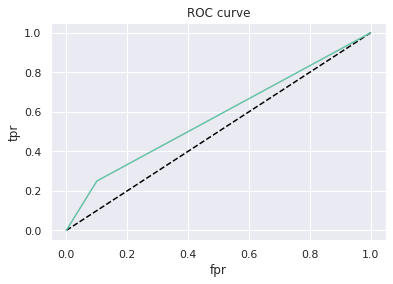

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

260/260 [==============================] - 0s 1ms/step


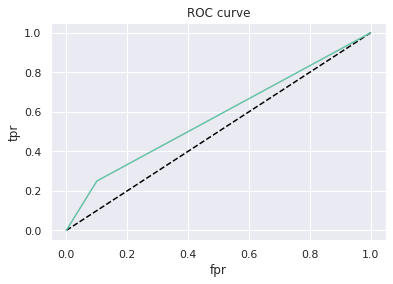

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,y_pred)
y_pred_proba = classifier.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()

    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(x_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

61/61 [==============================] - 0s 1ms/step


In [ ]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))